# **FGV EESP**

- ## VAR e VECM - Expectativa de Inflação do Mercado
---



### **Bibliotecas**

In [ ]:
# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

# Função tidy()
install.packages("broom")

# Painel de Gráficos
install.packages("gridExtra")

In [ ]:
library(broom)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(httr)
library(lubridate)
library(readxl)
library(tsDyn)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [3]:
# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/public_data.xlsx"

# Download do arquivo
download.file(file_path, "public_data.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_public_data <- as.data.frame(read_excel("public_data.xlsx"))

# Converter year e month_name
df_public_data <- df_public_data %>%
  mutate(year = as.numeric(year),  # Converter year para numérico
         month_name = factor(month_name, levels = month.abb, ordered = TRUE))  # Converter month_name para um fator ordenado

# Converter month_date
df_public_data$month_date <- ymd(df_public_data$month_date)  # Converter month_date para formato Date

# Lista de variáveis para transformar em séries temporais
vars_to_convert <- c("month", "market_inflation_expectation", "consumer_inflation_expectation", "consumer_confidence_index", "inflation_target", "inflation_target_lower_bound", "inflation_target_upper_bound", "inflation_target_wtd_avg", "inflation_target_lower_bound_wtd_avg", "inflation_target_upper_bound_wtd_avg", "ipca", "selic", "selic_deflated", "real_household_income", "real_household_income_trend", "real_household_income_gap", "real_exchange_rate", "real_exchange_rate_trend", "real_exchange_rate_gap", "gdp", "primary_fiscal_result", "primary_fiscal_result_to_gdp", "ipca_lag", "selic_deflated_lag", "primary_fiscal_result_to_gdp_lag", "real_exchange_rate_gap_lag", "real_household_income_gap_lag", "consumer_confidence_index_lag", "search_term_ipca", "search_term_selic", "search_term_inflation")

# Loop para transformar as variáveis em séries temporais
for (var in vars_to_convert) {
  df_public_data[[var]] <- ts(df_public_data[[var]], start = c(2006, 1), frequency = 12)
}

In [4]:
str(df_public_data)

'data.frame':	213 obs. of  34 variables:
 $ year                                : num  2006 2006 2006 2006 2006 ...
 $ month_name                          : Ord.factor w/ 12 levels "Jan"<"Feb"<"Mar"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ month_date                          : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                               : Time-Series  from 2006 to 2024: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation        : Time-Series  from 2006 to 2024: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation      : Time-Series  from 2006 to 2024: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ consumer_confidence_index           : Time-Series  from 2006 to 2024: 93.3 92.8 93 91.8 90.7 90.7 91.2 91.8 91.5 94.3 ...
 $ inflation_target                    : Time-Series  from 2006 to 2024: 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 ...
 $ inflation_target_lower_bound        : Time-Series  from 2006 to 2024: 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2

### **Modelo VAR**

In [5]:
# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca", "inflation_target_wtd_avg", "primary_fiscal_result_to_gdp", "selic_deflated", "real_exchange_rate_gap", "real_household_income_gap", "consumer_confidence_index")]
var_model_variables <- var_model_variables %>% rename(inflation_expectation = market_inflation_expectation)
var_model_variables <- var_model_variables %>% rename(inflation_target = inflation_target_wtd_avg)

In [6]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2      2 


In [7]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "const")

tidy(var_model)

group,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
inflation_expectation,inflation_expectation.l1,1.110705364,0.075127409,14.7842894,1.277760e-33
inflation_expectation,ipca.l1,0.082743525,0.054394164,1.5211839,1.298419e-01
inflation_expectation,inflation_target.l1,2.798107014,3.069318608,0.9116378,3.630908e-01
inflation_expectation,primary_fiscal_result_to_gdp.l1,-3.304333345,2.156013044,-1.5326129,1.270004e-01
inflation_expectation,selic_deflated.l1,0.089225587,0.049079187,1.8179924,7.060777e-02
inflation_expectation,real_exchange_rate_gap.l1,0.007900707,0.004184201,1.8882235,6.048846e-02
inflation_expectation,real_household_income_gap.l1,0.054962503,0.037394373,1.4698068,1.432340e-01
inflation_expectation,consumer_confidence_index.l1,0.005226476,0.004106026,1.2728795,2.045841e-01
inflation_expectation,inflation_expectation.l2,-0.279645571,0.075694157,-3.6944143,2.865677e-04


In [8]:
summary(var_model)


VAR Estimation Results:
Endogenous variables: inflation_expectation, ipca, inflation_target, primary_fiscal_result_to_gdp, selic_deflated, real_exchange_rate_gap, real_household_income_gap, consumer_confidence_index 
Deterministic variables: const 
Sample size: 211 
Log Likelihood: 821.703 
Roots of the characteristic polynomial:
1.008 0.9697 0.9697 0.951  0.94  0.94 0.7825 0.7825 0.7118 0.7118 0.588 0.588 0.3765 0.1896 0.1635 0.1621
Call:
VAR(y = var_model_variables, p = 2, type = "const")


Estimation results for equation inflation_expectation: 
inflation_expectation = inflation_expectation.l1 + ipca.l1 + inflation_target.l1 + primary_fiscal_result_to_gdp.l1 + selic_deflated.l1 + real_exchange_rate_gap.l1 + real_household_income_gap.l1 + consumer_confidence_index.l1 + inflation_expectation.l2 + ipca.l2 + inflation_target.l2 + primary_fiscal_result_to_gdp.l2 + selic_deflated.l2 + real_exchange_rate_gap.l2 + real_household_income_gap.l2 + consumer_confidence_index.l2 + const 

       

In [9]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 1012.1, df = 640, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 1012.1, df = 640, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [10]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 7164, df = 15552, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 7164, df = 15552, p-value = 1



**Resultado**

- Como o p-value é **maior** que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [11]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2883, df = 16, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 260.49, df = 8, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2622.5, df = 8, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2883, df = 16, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 260.49, df = 8, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2622.5, df = 8, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

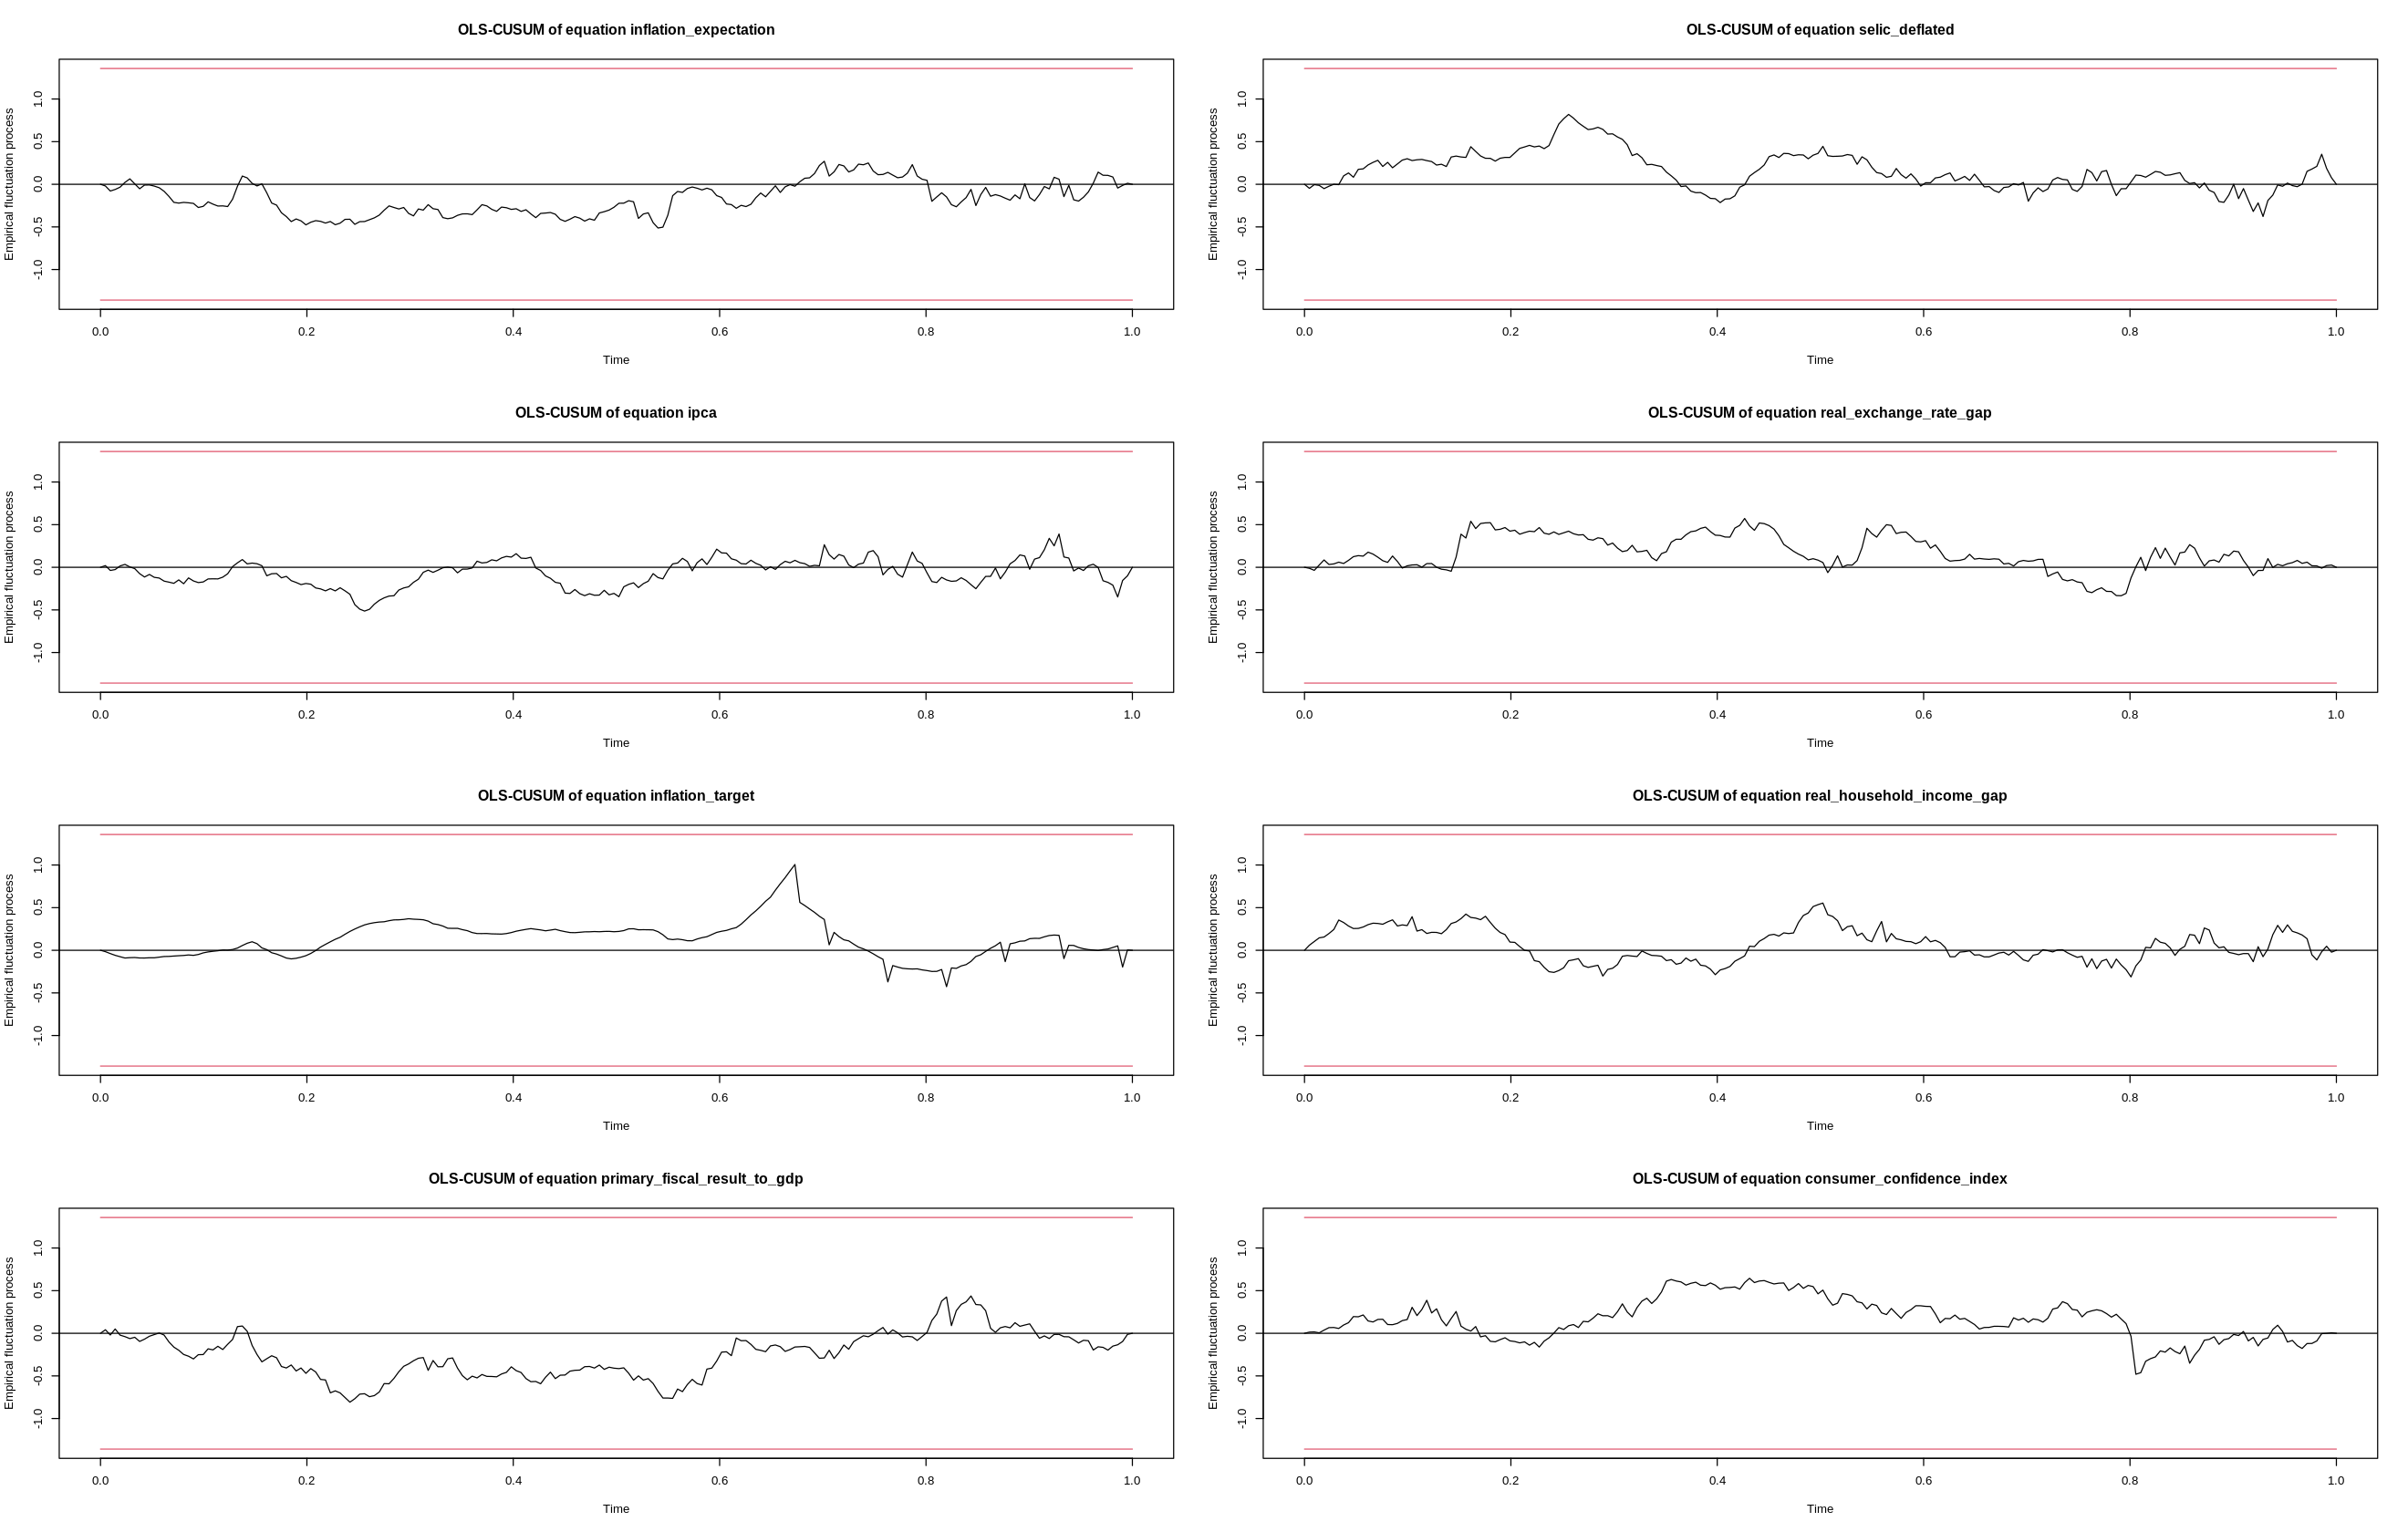

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 22, repr.plot.height = 14)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, com exceção da variável relacionada ao resultado fiscal, pode-se afirmar que não há quebra estrutural nos resíduos

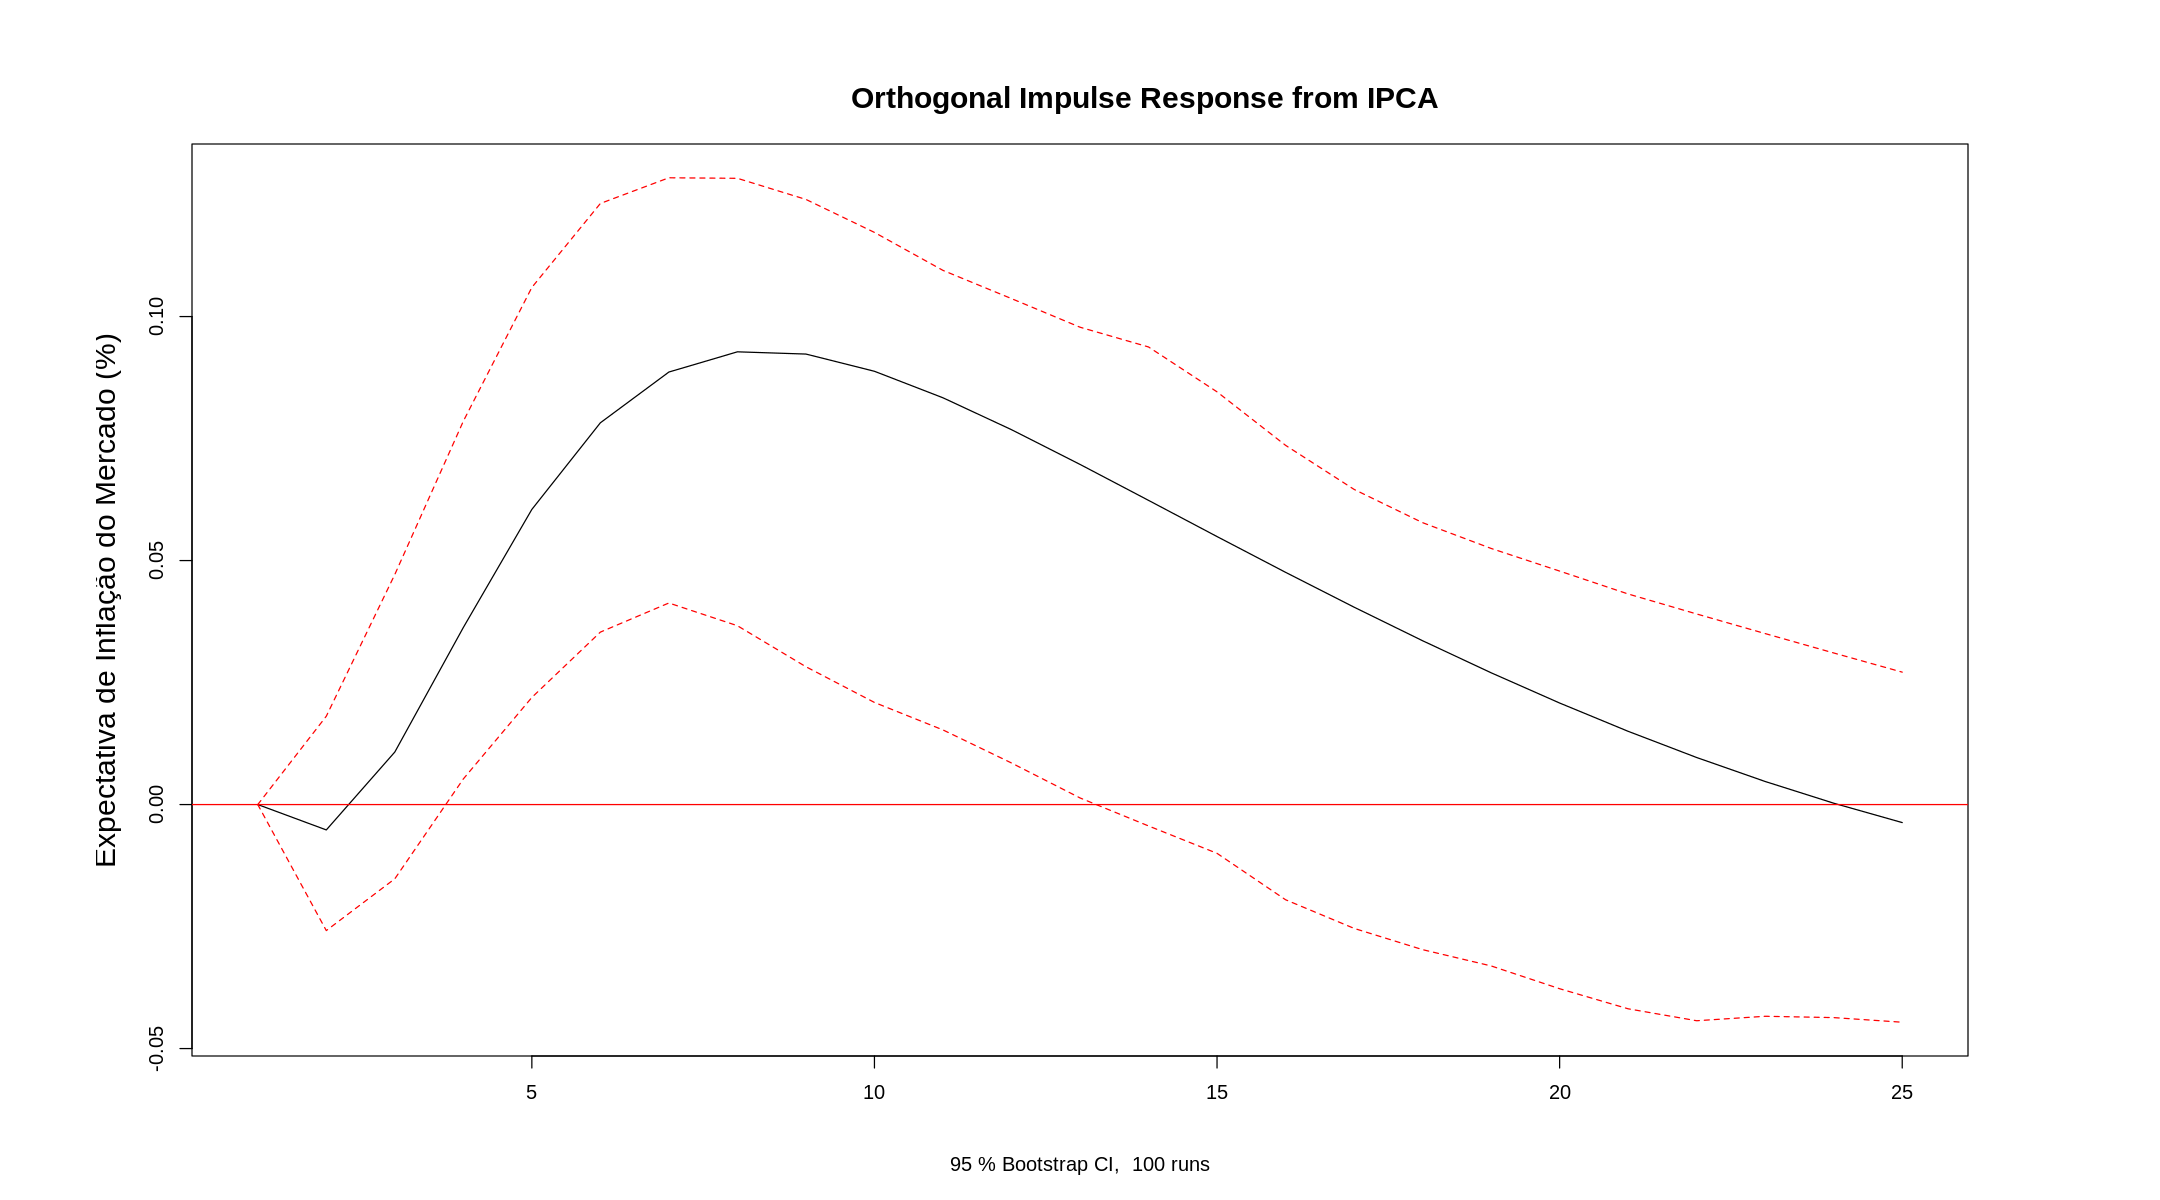

In [13]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 18, repr.plot.height = 10)

# Impulse Response Function
market_expectation_impulse = irf(var_model, impulse = "ipca", response = "inflation_expectation", n.ahead = 24, boot = TRUE)

# Criar o gráfico com tamanho de rótulo do eixo y aumentado
plot(market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "", cex.lab = 1.5)
title("Orthogonal Impulse Response from IPCA", cex.main = 1.5)

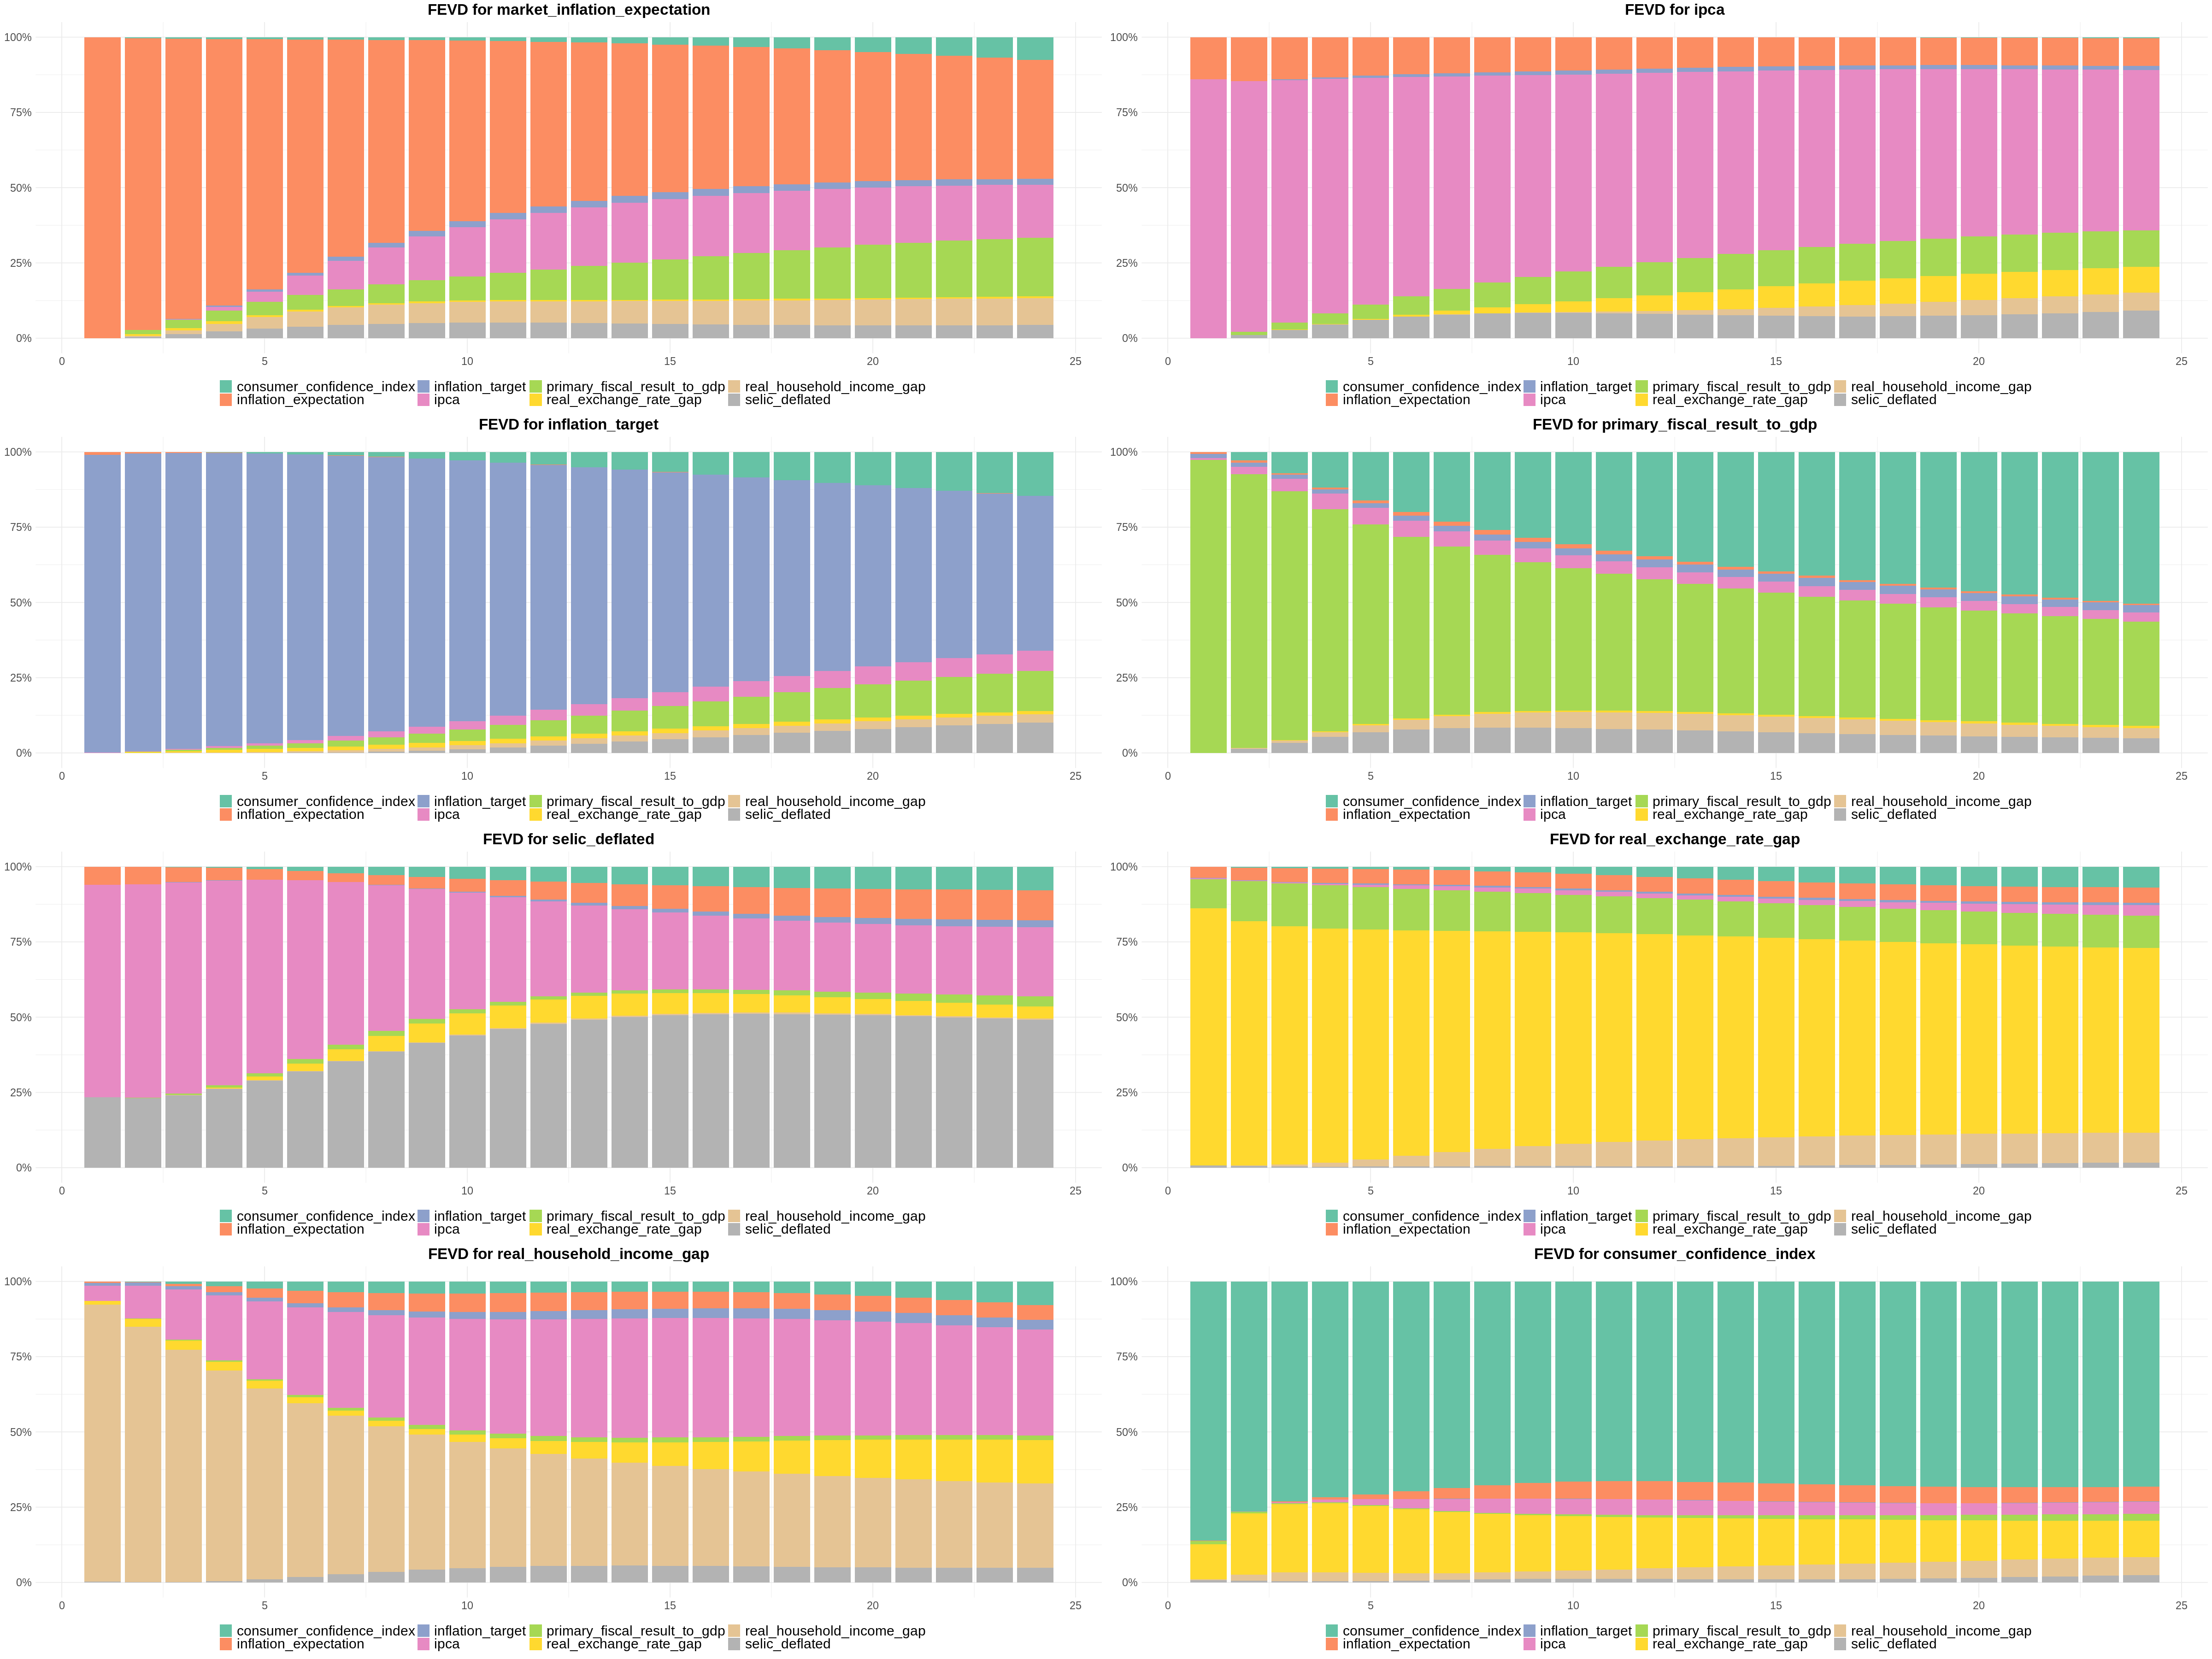

In [14]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 40, repr.plot.height = 30)

# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

# Criar uma lista com os data frames
data_list <- list(
  market_inflation_expectation = as.data.frame(fevd_model$inflation_expectation),
  ipca = as.data.frame(fevd_model$ipca),
  inflation_target = as.data.frame(fevd_model$inflation_target),
  primary_fiscal_result_to_gdp = as.data.frame(fevd_model$primary_fiscal_result_to_gdp),
  selic_deflated = as.data.frame(fevd_model$selic_deflated),
  real_exchange_rate_gap = as.data.frame(fevd_model$real_exchange_rate_gap),
  real_household_income_gap = as.data.frame(fevd_model$real_household_income_gap),
  consumer_confidence_index = as.data.frame(fevd_model$consumer_confidence_index)
)

# Adicionar a coluna "Mes" de 1 a 24 a cada data frame
data_list <- lapply(data_list, function(df) {
  df$Mes <- 1:24
  return(df)
})

# Função para criar os gráficos
create_stacked_bar_plot <- function(data, title) {
  ggplot(data, aes(x = Mes, y = value, fill = Variavel)) +
    geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_brewer(palette = "Set2") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "bottom",
      axis.text = element_text(size = 14),
      legend.text = element_text(size = 18),
      plot.title = element_text(hjust = 0.5, size = 20, face = "bold")
    ) +
    labs(fill = NULL) +
    ggtitle(title)
}

# Criar os gráficos empilhados e armazená-los em uma lista
plot_list <- lapply(names(data_list), function(name) {
  data <- data_list[[name]]
  title <- paste("FEVD for", name)
  data_long <- pivot_longer(data, cols = -Mes, names_to = "Variavel", values_to = "value")
  create_stacked_bar_plot(data_long, title)
})

# Plotar os gráficos em um painel
grid.arrange(grobs = plot_list, ncol = 2)  # Altere ncol conforme necessário

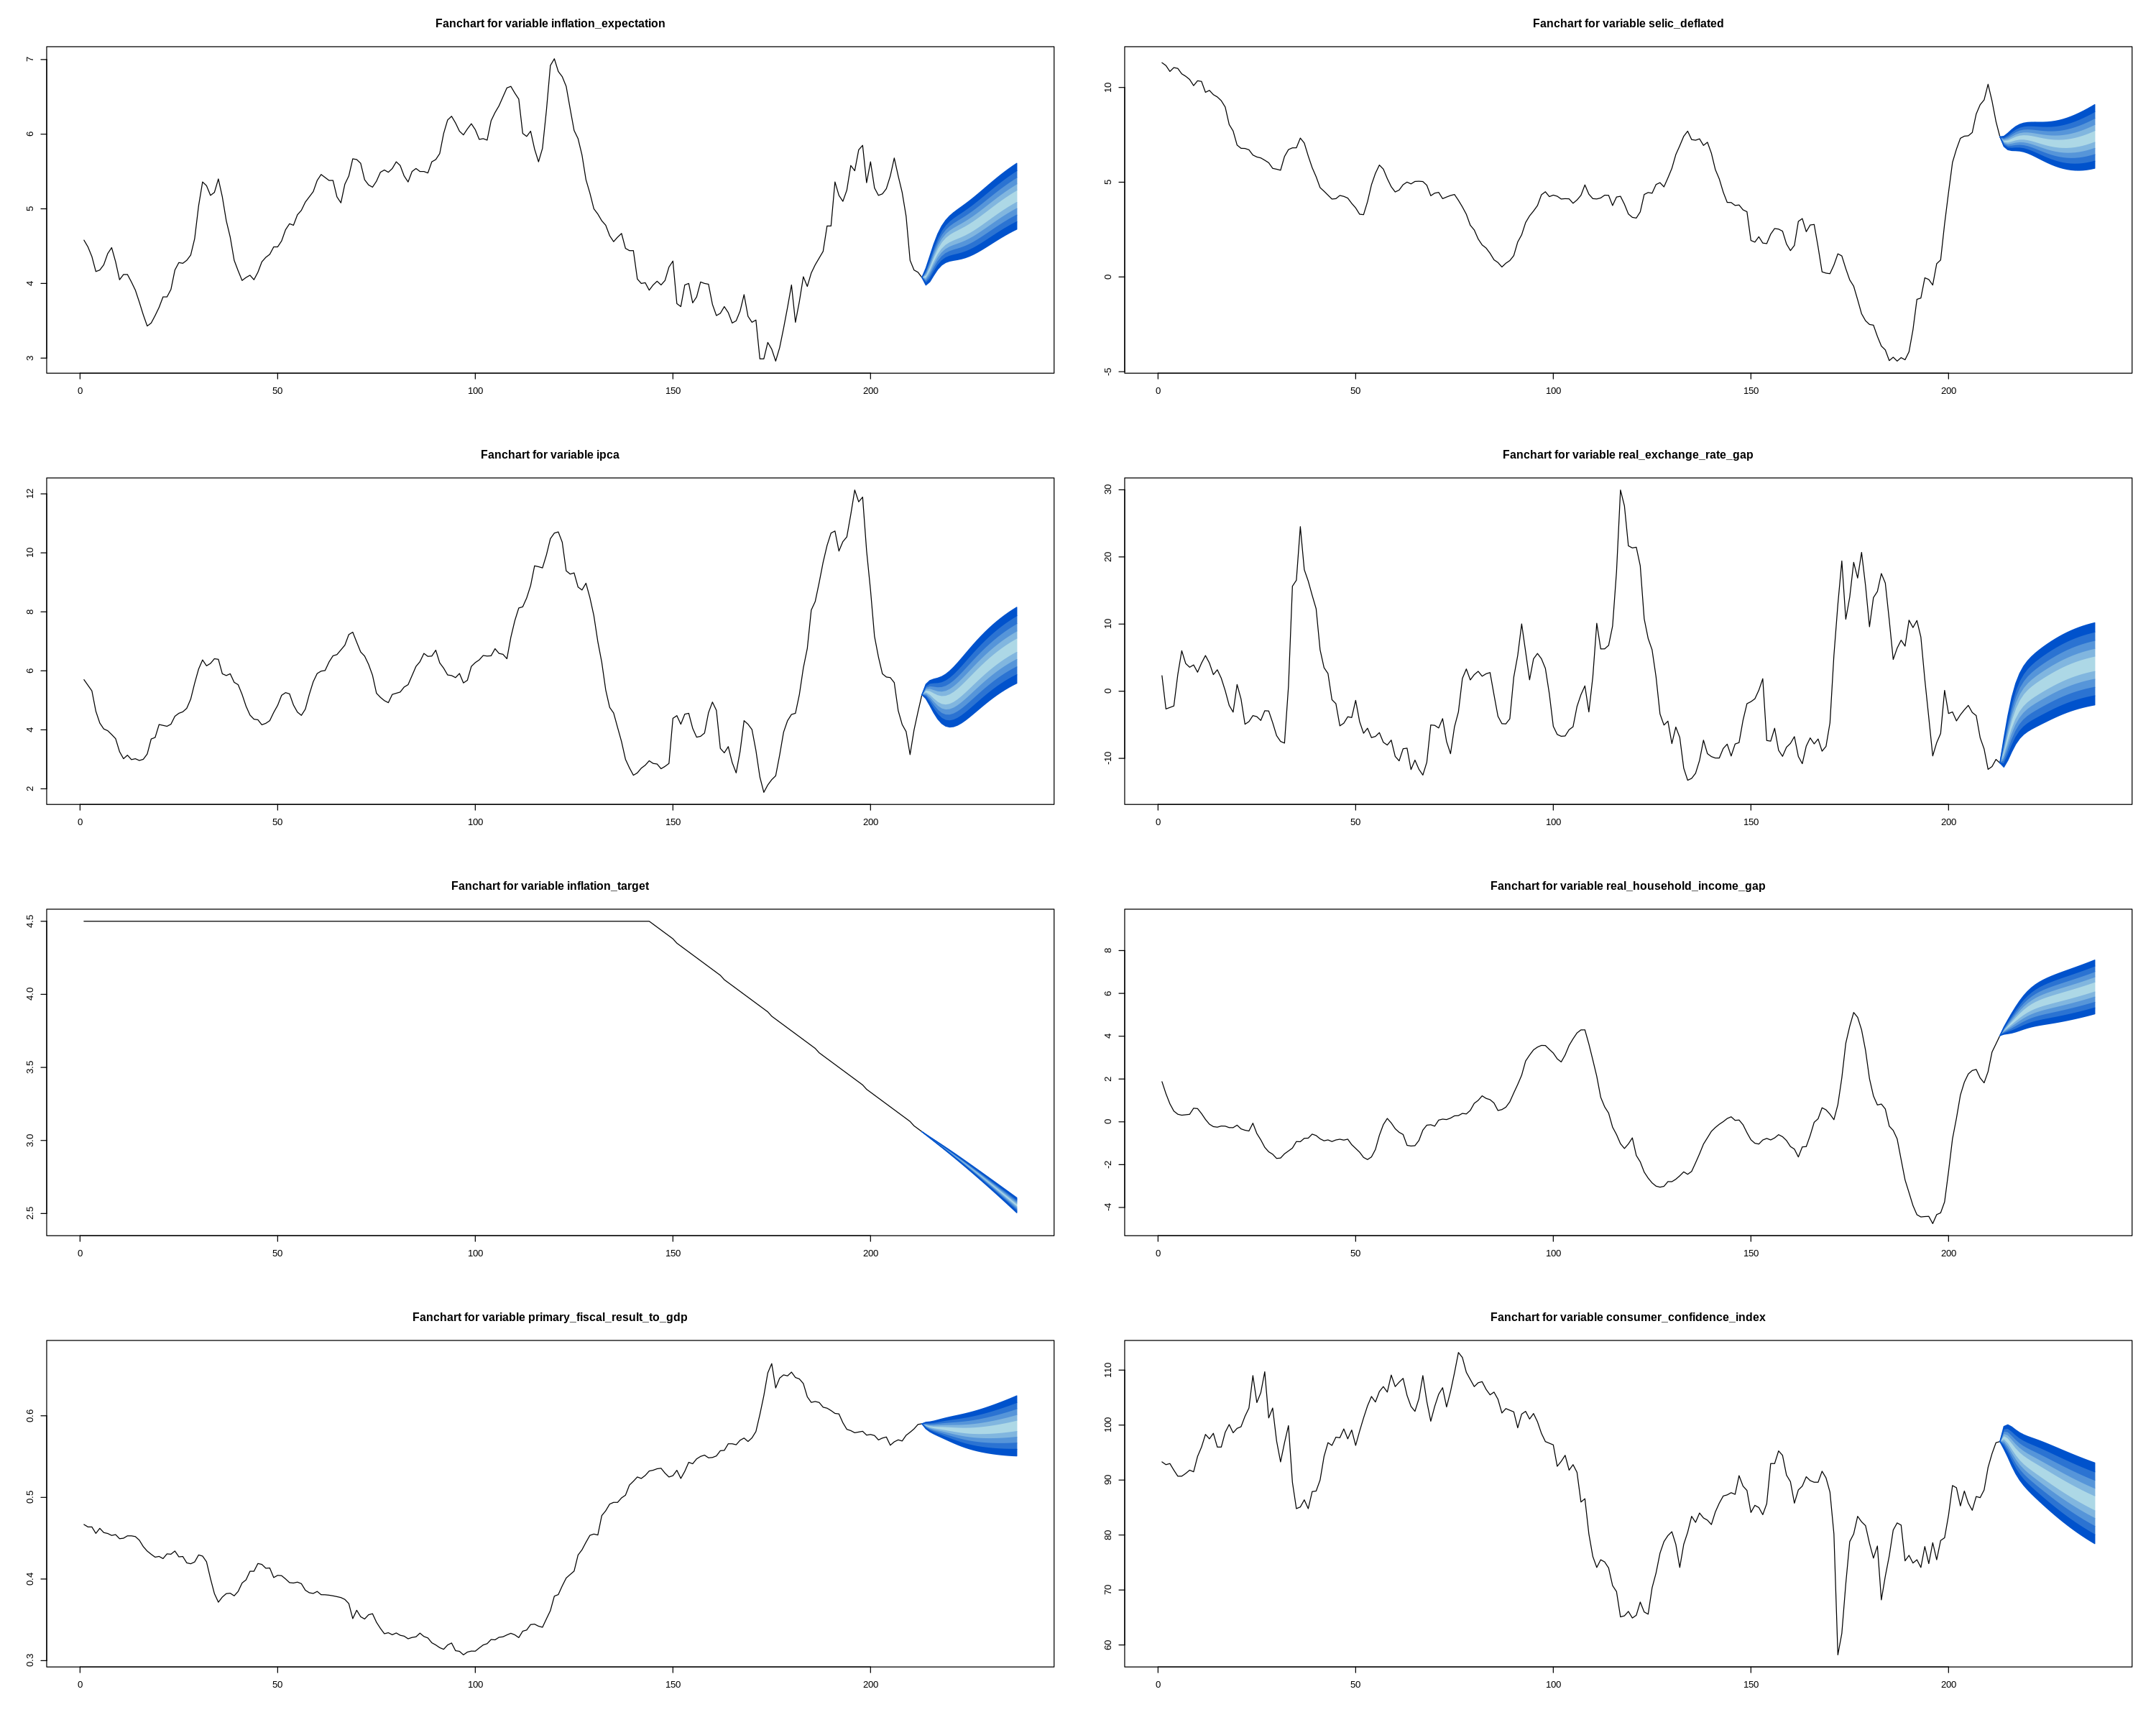

In [15]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 20)

# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

# Definir um degradê de cores azul com 5 tons
blue_gradient <- colorRampPalette(c("#ADD8E6", "#0052CC"))(5)

# Criar um gráfico de intervalo de previsão usando o degradê azul personalizado com 5 tons
fanchart(forecast_var, colors=blue_gradient)

### **Modelo VECM**

In [16]:
# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca", "inflation_target_wtd_avg", "primary_fiscal_result_to_gdp", "selic_deflated", "real_exchange_rate_gap", "real_household_income_gap", "consumer_confidence_index")]
vecm_model_variables <- vecm_model_variables %>% rename(inflation_expectation = market_inflation_expectation)
vecm_model_variables <- vecm_model_variables %>% rename(inflation_target = inflation_target_wtd_avg)

In [17]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "const")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2      2 


In [18]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "const", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 2.709677e-01 2.007981e-01 1.746204e-01 1.442724e-01 1.255846e-01
[6] 8.099177e-02 6.608524e-02 5.977280e-03 4.183553e-17

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 7 |   1.26   7.52   9.24  12.97
r <= 6 |  15.69  17.85  19.96  24.60
r <= 5 |  33.51  32.00  34.91  41.07
r <= 4 |  61.83  49.65  53.12  60.16
r <= 3 |  94.70  71.86  76.07  84.45
r <= 2 | 135.20  97.18 102.14 111.01
r <= 1 | 182.49 126.58 131.70 143.09
r = 0  | 249.17 159.48 165.58 177.20

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                inflation_expectation.l2     ipca.l2
inflation_expectation.l2                      1.00000000  1.00000000
ipca.l2                                       0.34424927 -0.68300886
inflation_target.l

**Resultado**

- r <= 4: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 4 relações de cointegração no sistema

- r <= 5: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 4 relações de cointegração no sistema

In [19]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "const", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 2.709677e-01 2.007981e-01 1.746204e-01 1.442724e-01 1.255846e-01
[6] 8.099177e-02 6.608524e-02 5.977280e-03 4.183553e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 7 |  1.26  7.52  9.24 12.97
r <= 6 | 14.43 13.75 15.67 20.20
r <= 5 | 17.82 19.77 22.00 26.81
r <= 4 | 28.32 25.56 28.14 33.24
r <= 3 | 32.87 31.66 34.40 39.79
r <= 2 | 40.49 37.45 40.30 46.82
r <= 1 | 47.29 43.25 46.45 51.91
r = 0  | 66.68 48.91 52.00 57.95

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                inflation_expectation.l2     ipca.l2
inflation_expectation.l2                      1.00000000  1.00000000
ipca.l2                                       0.34424927 -0.68300886
inflation_target.l2         

**Resultado**

- r <= 4: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 4 relações de cointegração no sistema

- r <= 5: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 4 relações de cointegração no sistema

In [20]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 2, r = 4, estim = "ML")

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 213 	End sample size: 210
Number of variables: 8 	Number of estimated slope parameters 168
AIC -6101.384 	BIC -5485.516 	SSR 3913.308
Cointegrating vector (estimated by ML):
   inflation_expectation         ipca inflation_target
r1          1.000000e+00 9.873806e-17     1.199757e-17
r2          9.753546e-17 1.000000e+00    -4.162969e-17
r3         -7.940566e-19 2.117038e-17     1.000000e+00
r4          1.377817e-18 1.528896e-17    -2.837102e-17
   primary_fiscal_result_to_gdp selic_deflated real_exchange_rate_gap
r1                 8.881784e-16     0.18529370           0.0757416446
r2                 1.776357e-15     0.28571780           0.0545205695
r3                 4.440892e-16     0.02901631          -0.0049995737
r4                 1.000000e+00    -0.01051884          -0.0007320467
   real_household_income_gap consumer_confidence_index
r1               -0.50122083                0.07115731
r2               -0.68505991  

In [21]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 4)

In [22]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 1031.9, df = 648, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 1031.9, df = 648, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [23]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 7164, df = 15552, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 7164, df = 15552, p-value = 1



**Resultado**

- Como o p-value é maior que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [24]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3863.6, df = 16, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 231.64, df = 8, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3631.9, df = 8, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3863.6, df = 16, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 231.64, df = 8, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3631.9, df = 8, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

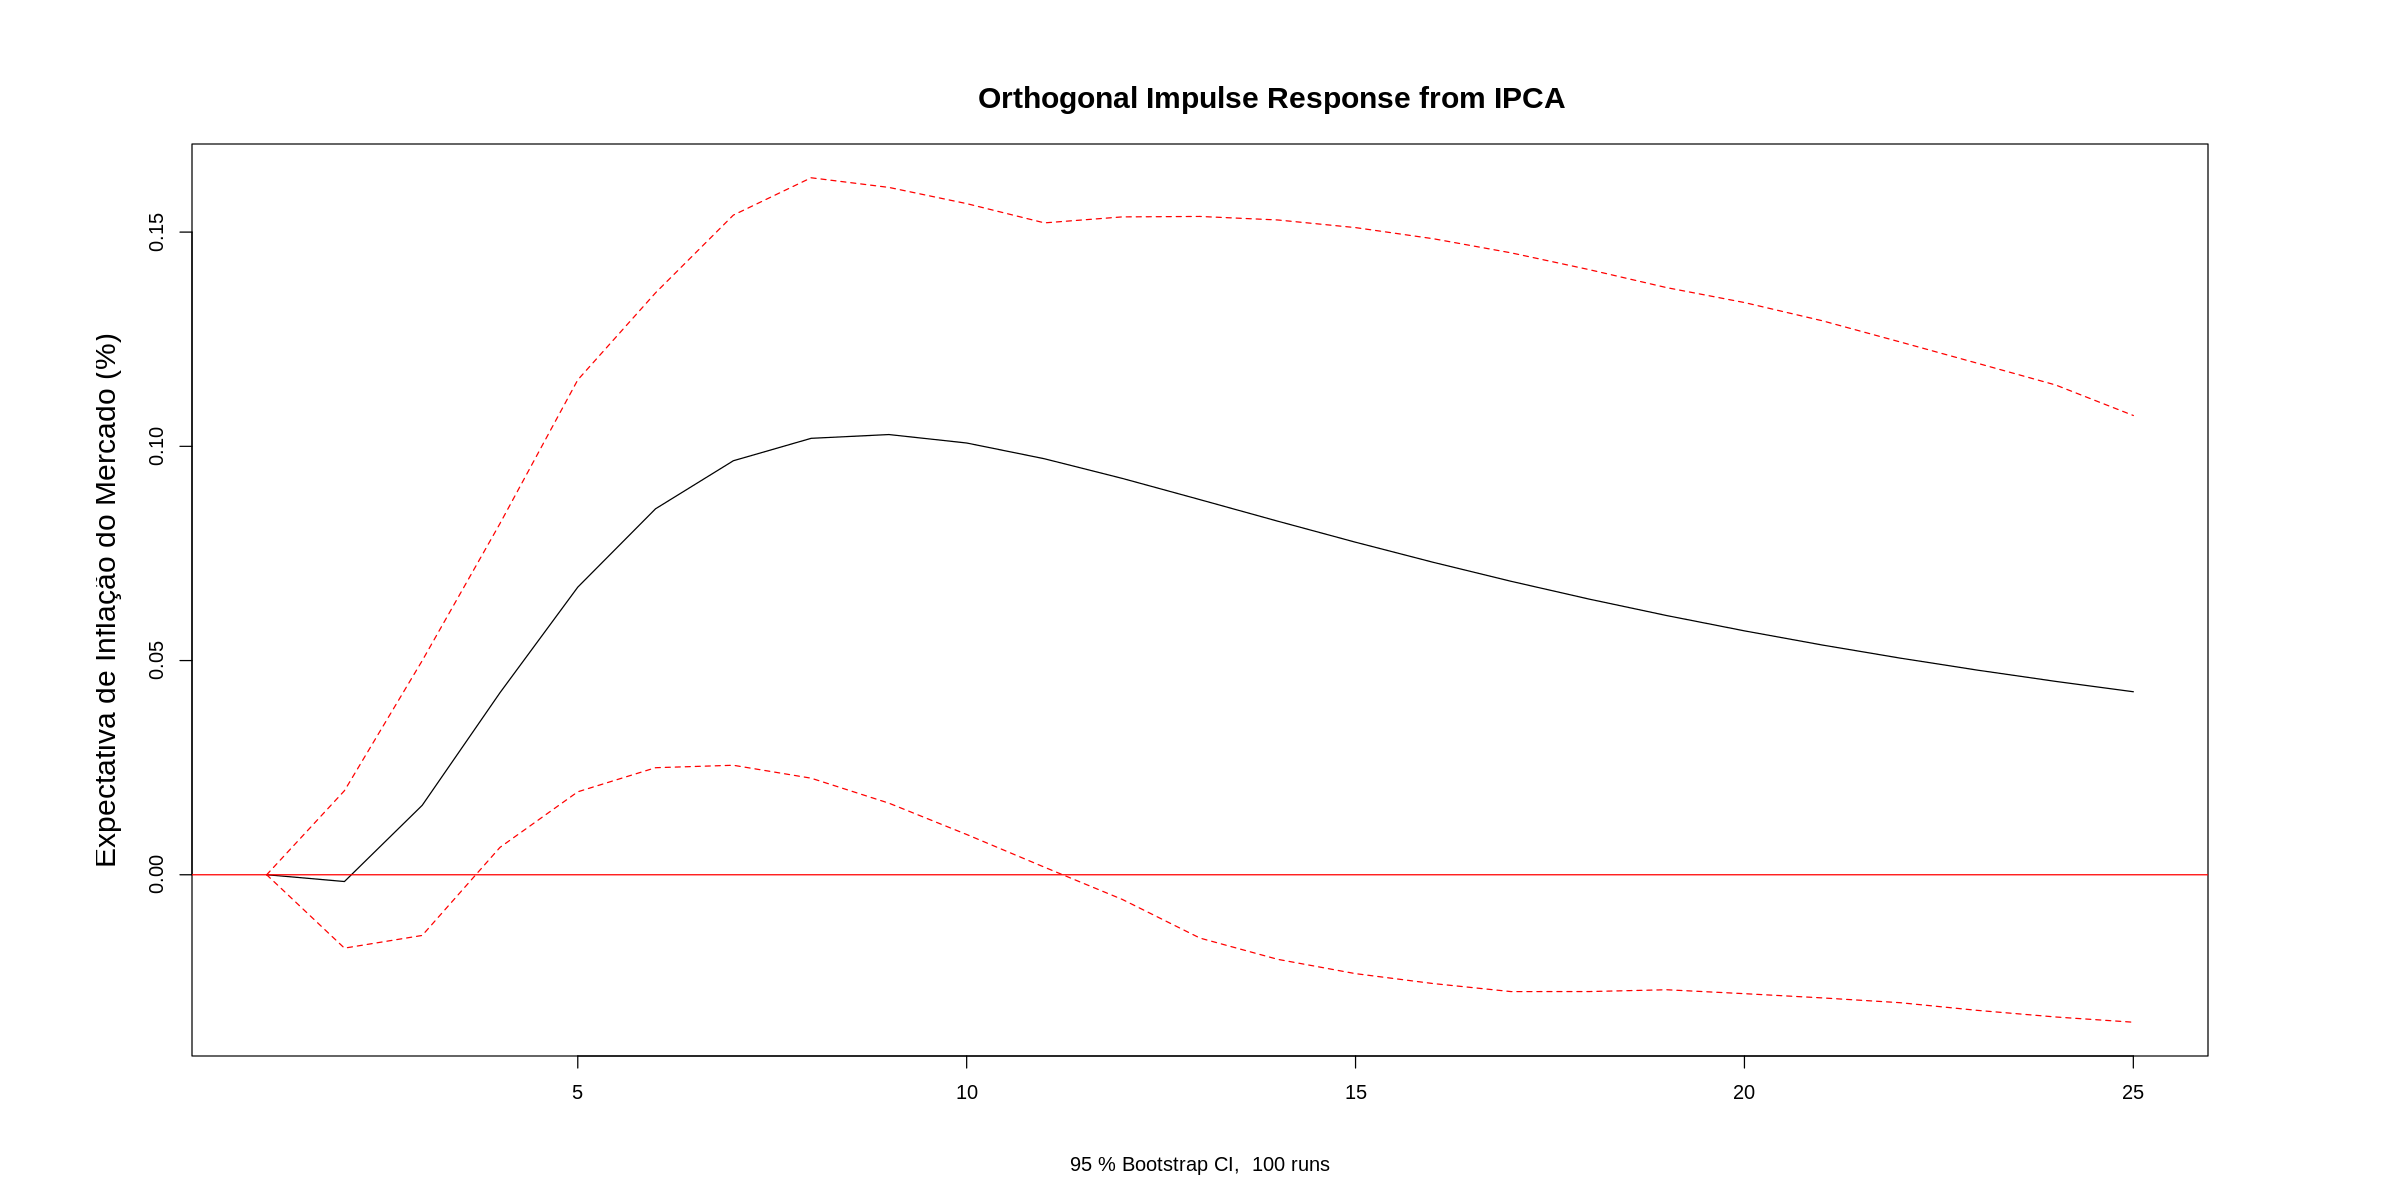

In [25]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Impulse Response Function
vecm_ipca_market_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca", response = "inflation_expectation", n.ahead = 24, boot = TRUE)

# Criar o gráfico com tamanho de rótulo do eixo y aumentado
plot(vecm_ipca_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "", cex.lab = 1.5)
title("Orthogonal Impulse Response from IPCA", cex.main = 1.5)

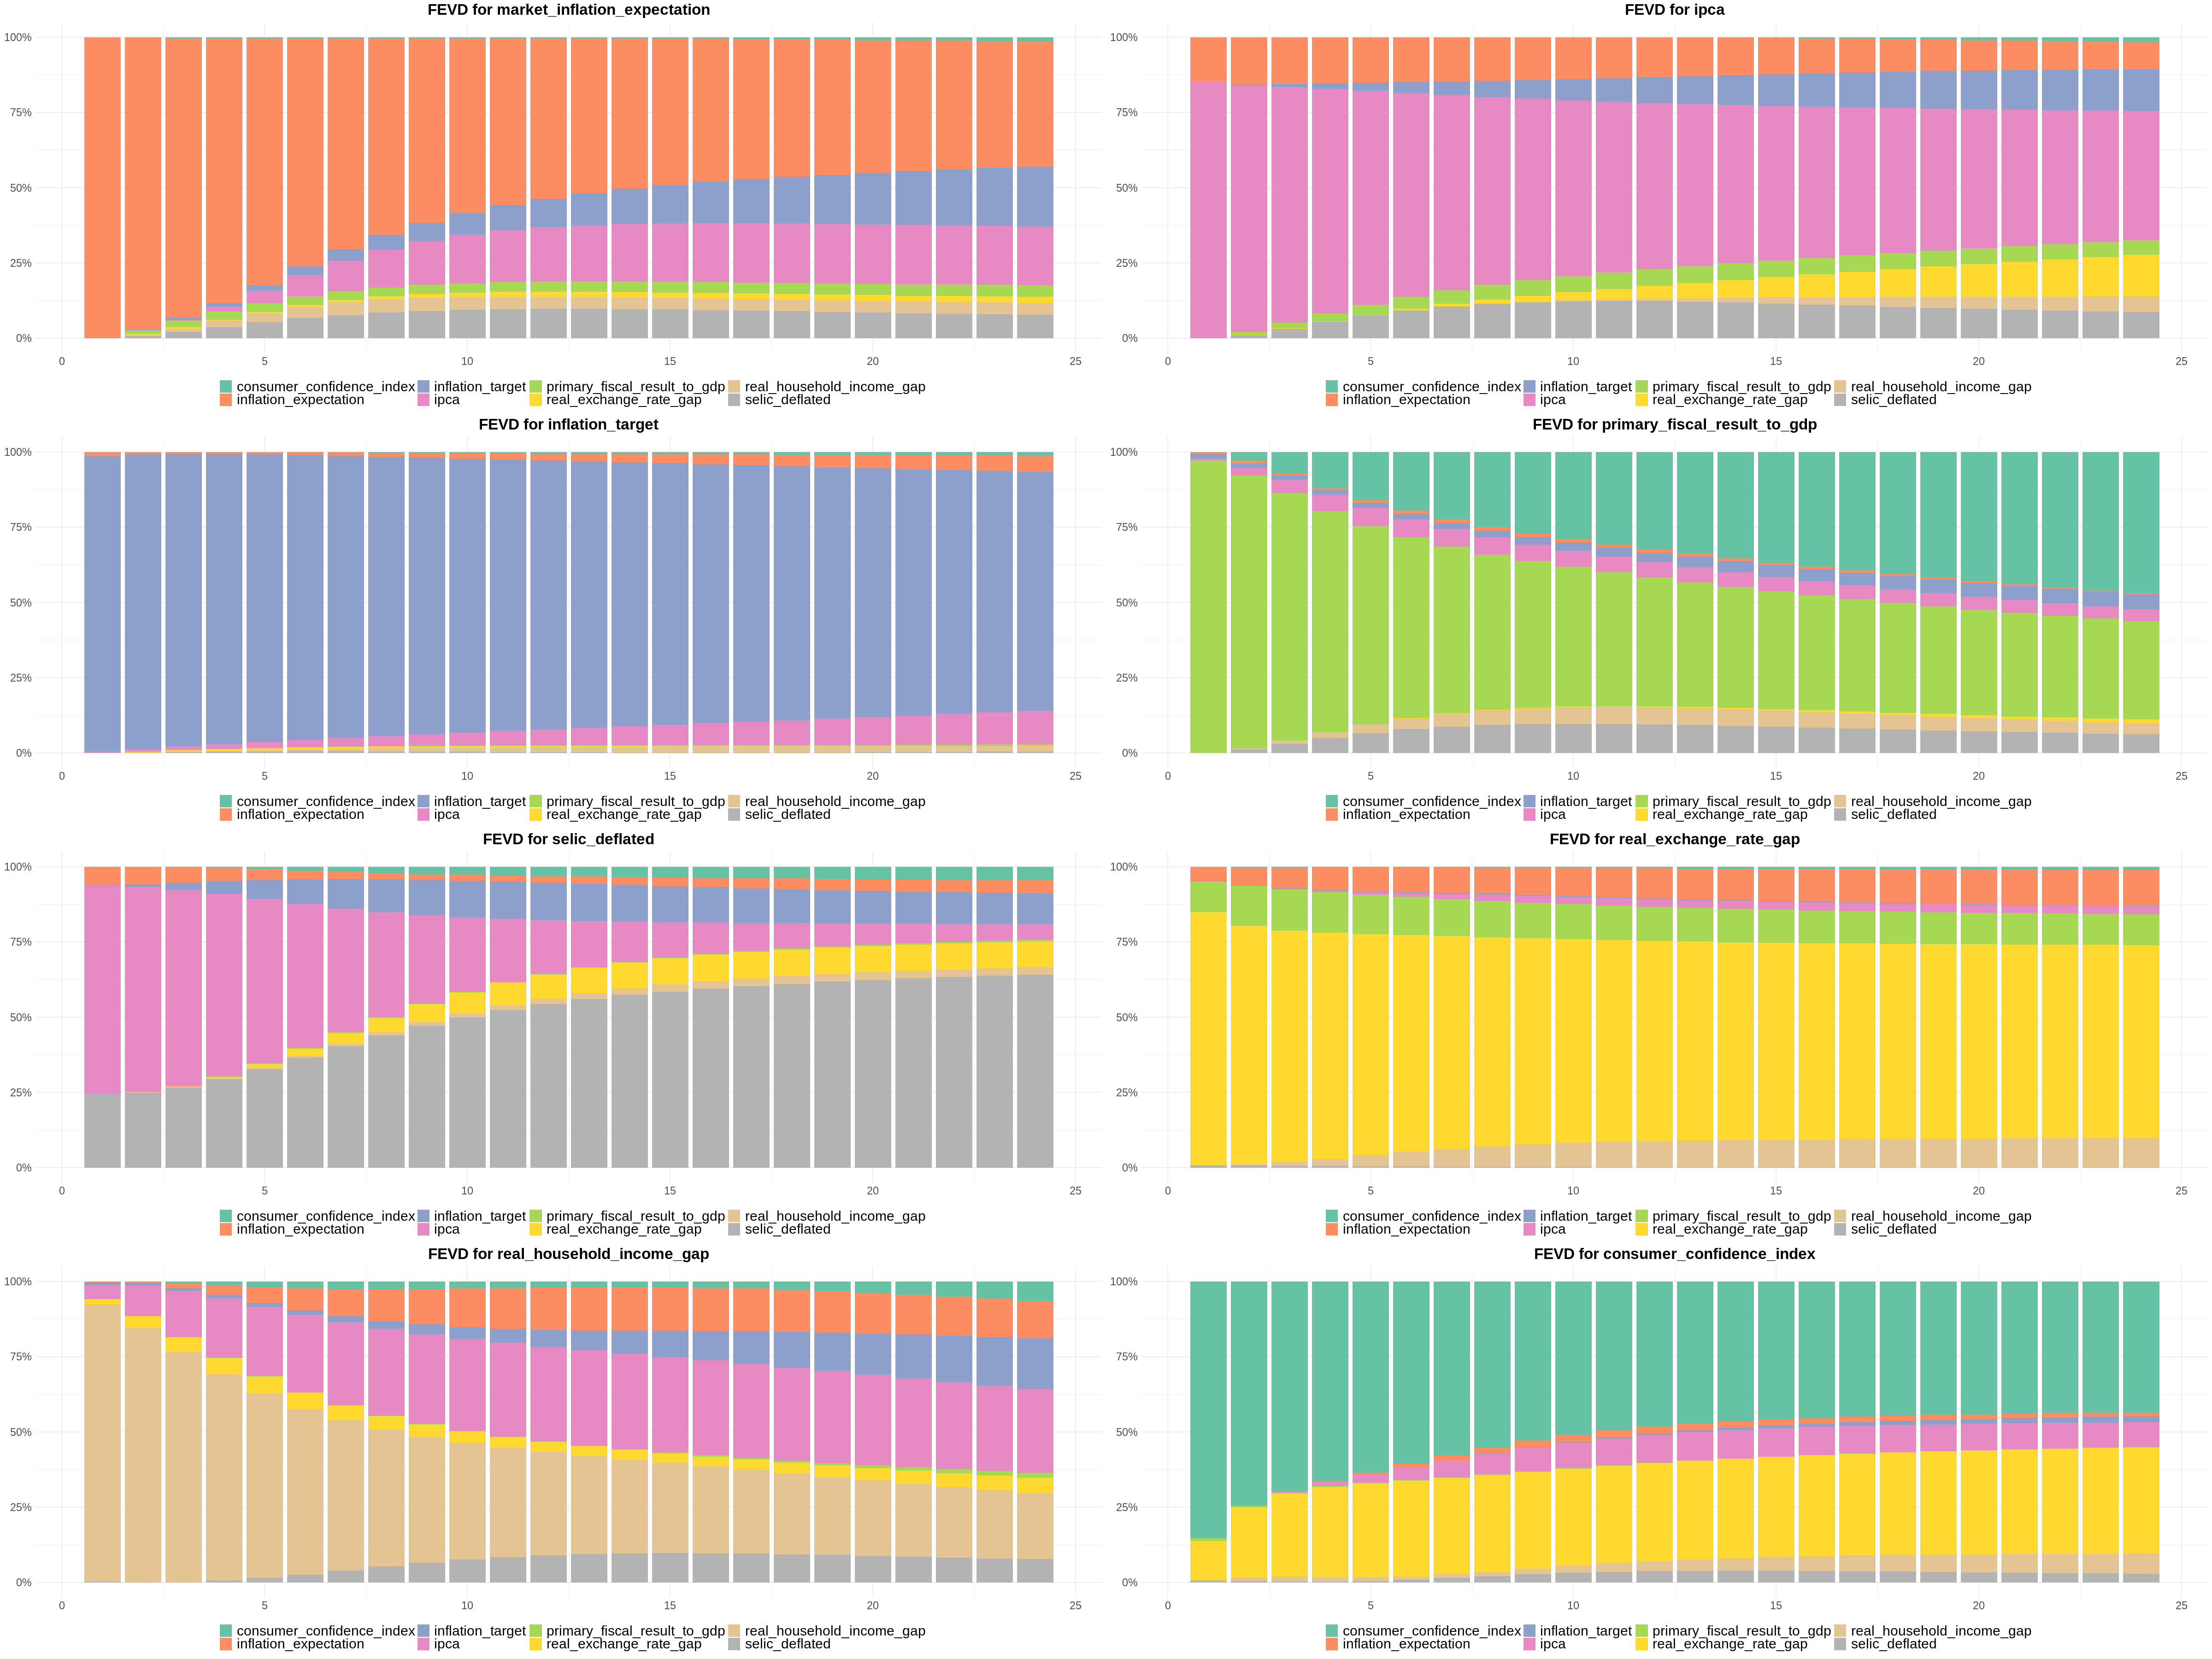

In [26]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 40, repr.plot.height = 30)

# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

# Criar uma lista com os data frames
data_list <- list(
  market_inflation_expectation = as.data.frame(vecm_fevd$inflation_expectation),
  ipca = as.data.frame(vecm_fevd$ipca),
  inflation_target = as.data.frame(vecm_fevd$inflation_target),
  primary_fiscal_result_to_gdp = as.data.frame(vecm_fevd$primary_fiscal_result_to_gdp),
  selic_deflated = as.data.frame(vecm_fevd$selic_deflated),
  real_exchange_rate_gap = as.data.frame(vecm_fevd$real_exchange_rate_gap),
  real_household_income_gap = as.data.frame(vecm_fevd$real_household_income_gap),
  consumer_confidence_index = as.data.frame(vecm_fevd$consumer_confidence_index)
)

# Adicionar a coluna "Mes" de 1 a 24 a cada data frame
data_list <- lapply(data_list, function(df) {
  df$Mes <- 1:24
  return(df)
})

# Função para criar os gráficos
create_stacked_bar_plot <- function(data, title) {
  ggplot(data, aes(x = Mes, y = value, fill = Variavel)) +
    geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_brewer(palette = "Set2") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "bottom",
      axis.text = element_text(size = 14),
      legend.text = element_text(size = 18),
      plot.title = element_text(hjust = 0.5, size = 20, face = "bold")
    ) +
    labs(fill = NULL) +
    ggtitle(title)
}

# Criar os gráficos empilhados e armazená-los em uma lista
plot_list <- lapply(names(data_list), function(name) {
  data <- data_list[[name]]
  title <- paste("FEVD for", name)
  data_long <- pivot_longer(data, cols = -Mes, names_to = "Variavel", values_to = "value")
  create_stacked_bar_plot(data_long, title)
})

# Plotar os gráficos em um painel
grid.arrange(grobs = plot_list, ncol = 2)  # Altere ncol conforme necessário

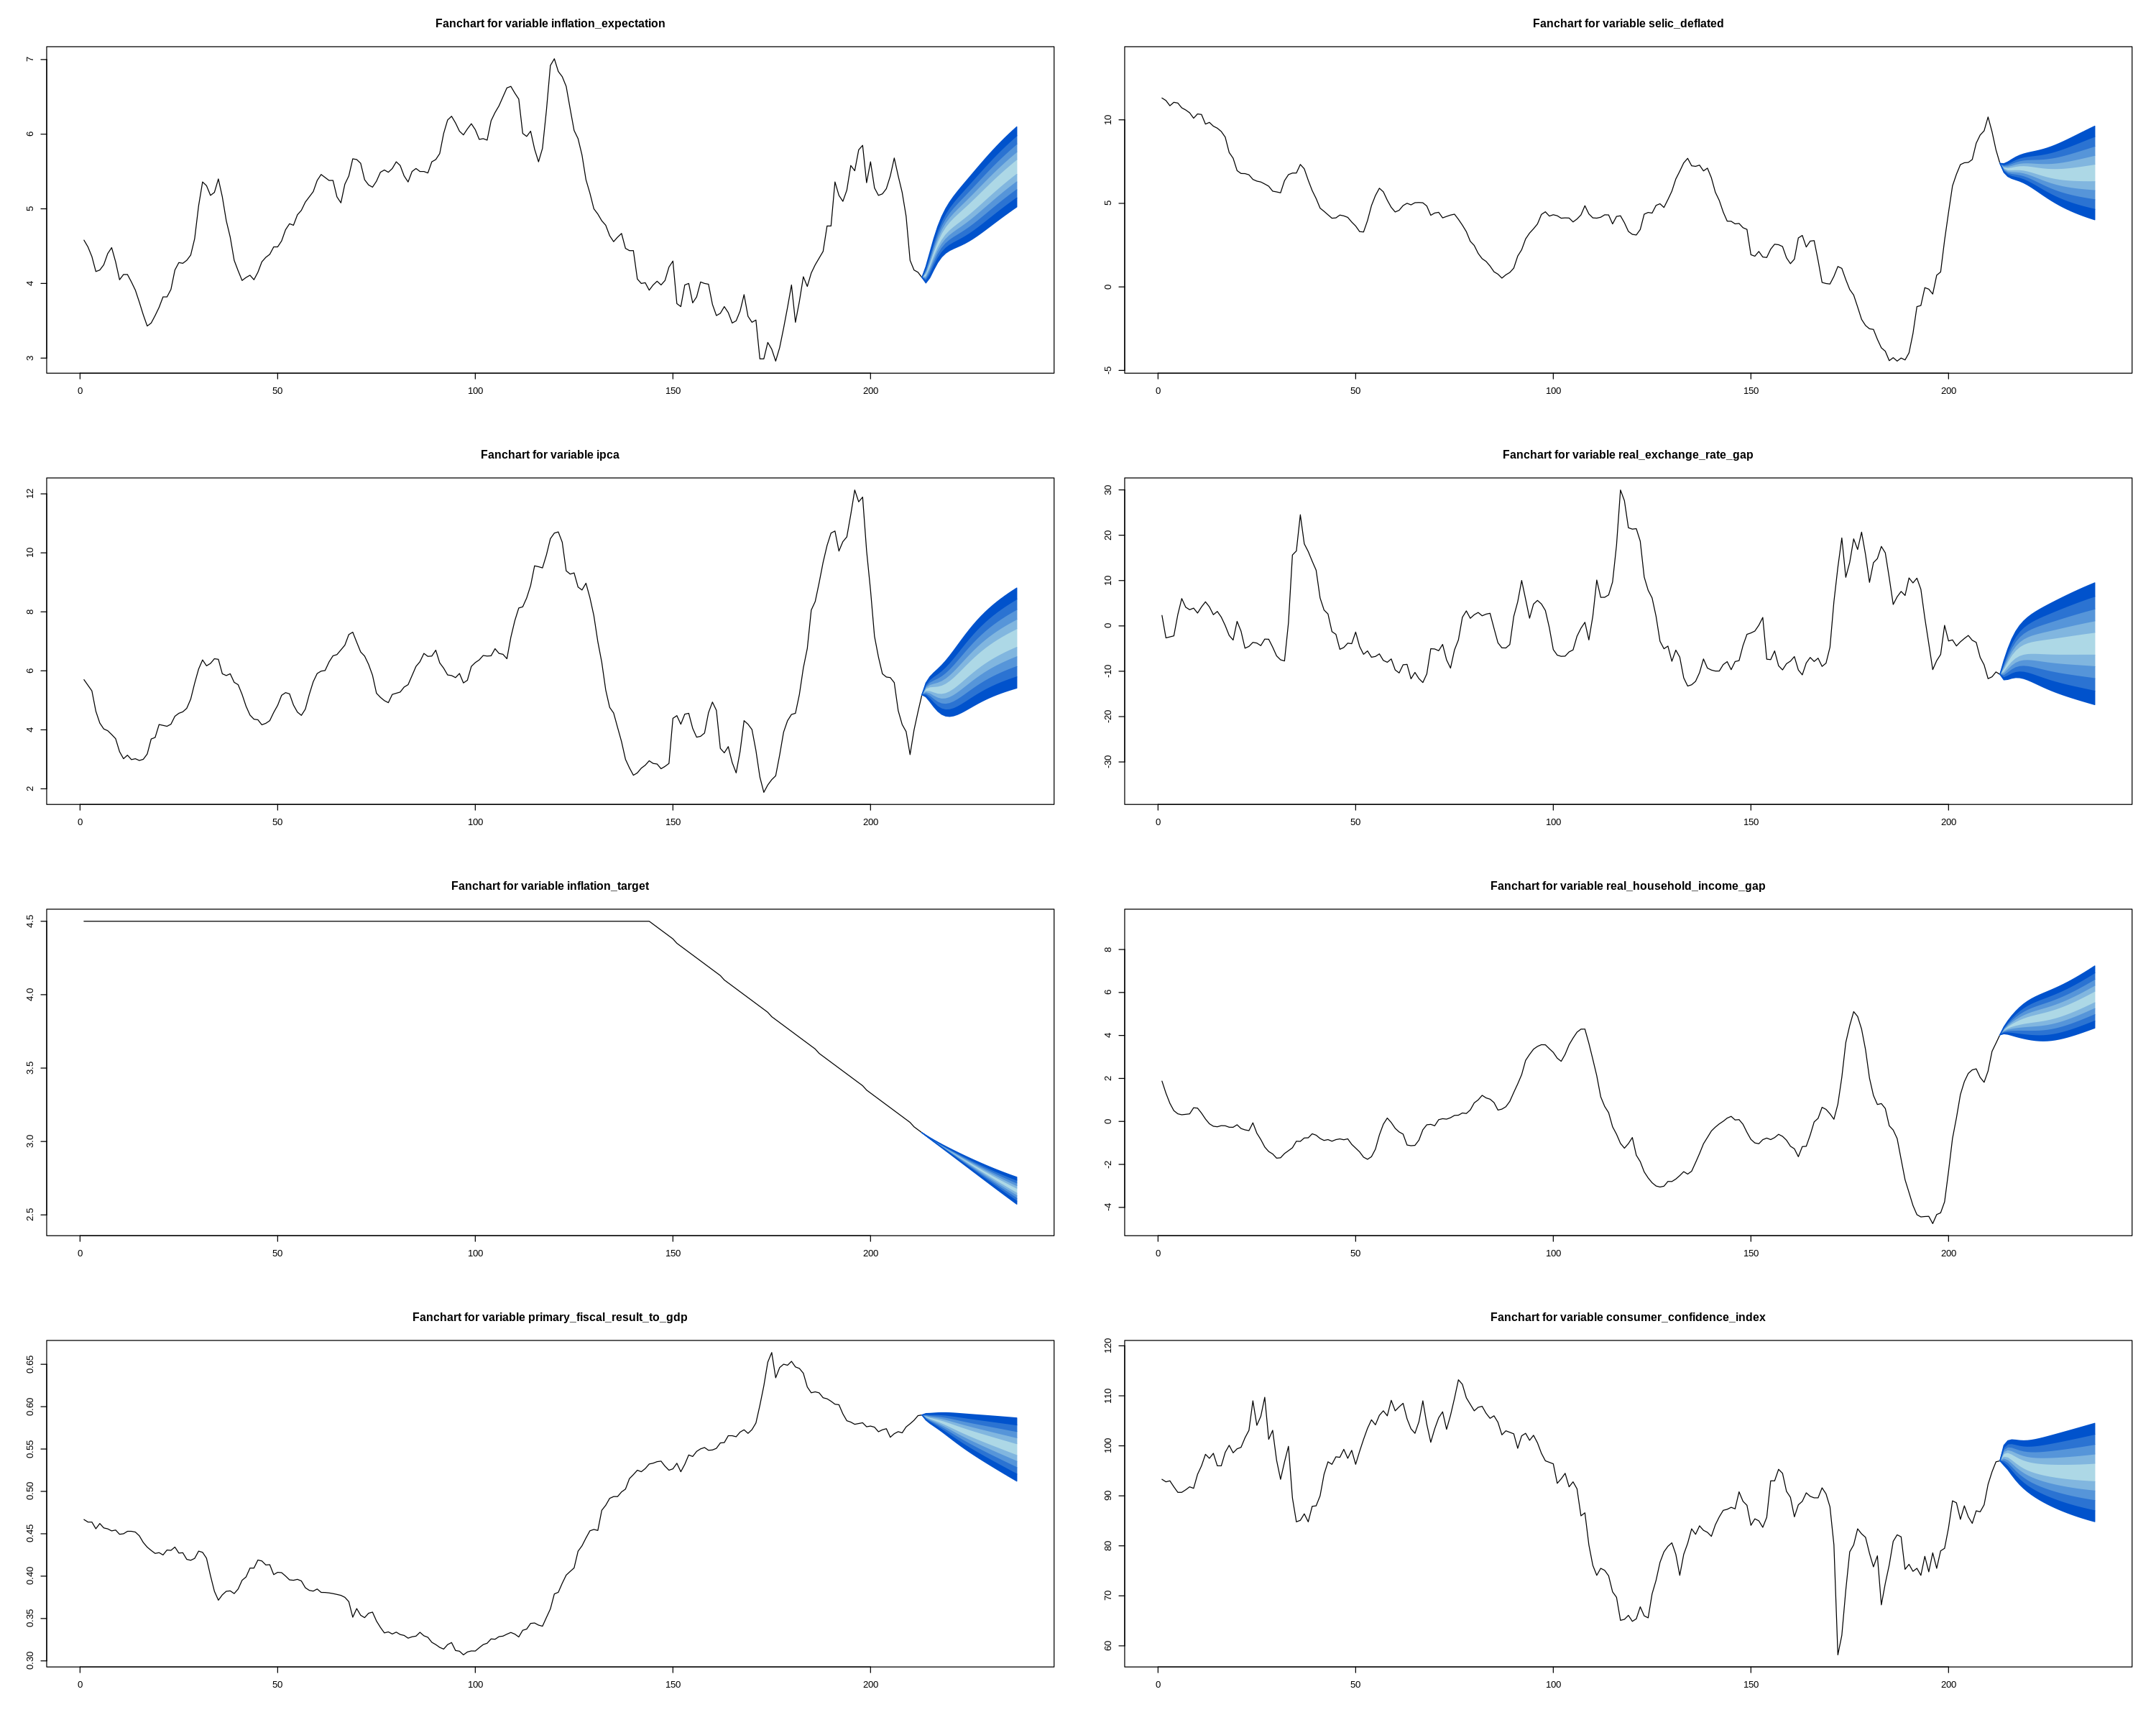

In [27]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 20)

# Forecast using VAR
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

# Definir um degradê de cores azul com 5 tons
blue_gradient <- colorRampPalette(c("#ADD8E6", "#0052CC"))(5)

# Criar um gráfico de intervalo de previsão usando o degradê azul personalizado com 5 tons
fanchart(forecast_vecm, colors=blue_gradient)